In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib
from tqdm import tqdm
import matplotlib.gridspec as gridspec
import emcee
import corner
from multiprocessing import Pool
import time

#matplotlib settings for pretty plots

#matplotlib.rc('text',usetex=True)
font = {'family' : 'serif',
#        'weight' : 'bold',
        'size'   : 16,}
matplotlib.rc('font', **font)

homeword_path = '/Users/kevinm/Documents/UCSC/Year3/Quarter3/STATS222/Homework/'
path = '/Users/kevinm/Documents/UCSC/Year3/Quarter3/STATS222/Project/'

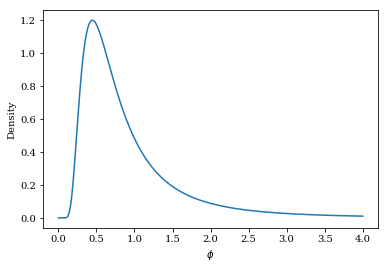

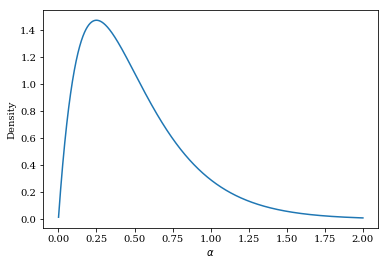

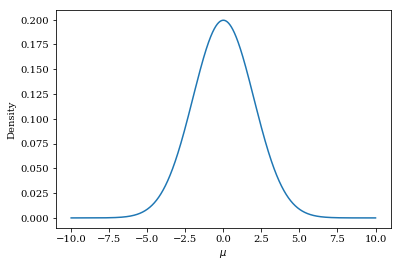

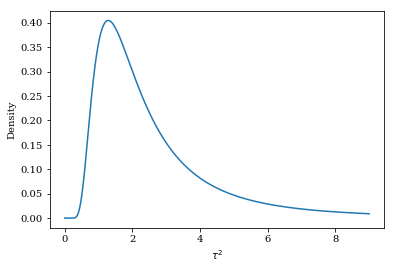

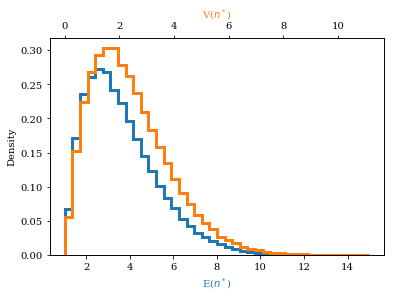

In [2]:
"""Defining the Prior Distributions""""

np.random.seed(101)
data = np.genfromtxt(f'{homeword_path}hwk3-data.txt')
n = len(data)
n_obs = 4000

plot_priors = True

#set up priors
#variance of normal kernel
phi_mean,phi_sd = 1,1
a_phi = 3/2. + (np.sqrt(4*phi_mean*phi_sd**2+phi_sd**4))/(2*phi_sd**2)
b_phi = (phi_mean/(2*phi_sd**2))*(phi_sd**2 + np.sqrt(4*phi_mean*phi_sd**2+phi_sd**4))

#discreteness parameter
b_alpha = 4
a_alpha = 2
alpha_mean,alpha_sd = a_alpha/b_alpha,a_alpha/(b_alpha)**2

#mean of normal baseline distribution
mu_mean,mu_sd = 0,2
a_mu,b_mu = mu_mean,mu_sd**2

#variance of normal baseline distribution
tau2_mean,tau2_sd = 3,2
a_tau2 = 3/2. + (np.sqrt(4*tau2_mean*tau2_sd**2+tau2_sd**4))/(2*tau2_sd**2)
b_tau2 = (tau2_mean/(2*tau2_sd**2))*(tau2_sd**2 + np.sqrt(4*tau2_mean*tau2_sd**2+tau2_sd**4))
#G0 = stats.normal(loc=mu,scale=np.sqrt(tau2))

phi_prior = stats.invgamma(a=a_phi,scale=b_phi)
alpha_prior = stats.gamma(a=a_alpha,scale=1/b_alpha)
mu_prior = stats.norm(loc=a_mu,scale=np.sqrt(b_mu))
tau2_prior = stats.invgamma(a=a_tau2,scale=b_tau2)

if plot_priors:
    phis = np.linspace(0.001,phi_mean+3*phi_sd,10000)
    plt.plot(phis,phi_prior.pdf(phis))
    plt.xlabel(r'$\phi$');plt.ylabel('Density')
    plt.show()

    alphas = np.linspace(max(0.001,alpha_mean-5*alpha_sd),max(2,alpha_mean+5*alpha_sd),10000)
    plt.plot(alphas,alpha_prior.pdf(alphas))
    plt.xlabel(r'$\alpha$');plt.ylabel('Density')
    plt.show()

    mus = np.linspace(mu_mean-5*mu_sd,mu_mean+5*mu_sd,10000)
    plt.plot(mus,mu_prior.pdf(mus))
    plt.xlabel(r'$\mu$');plt.ylabel('Density')
    plt.show()

    tau2s = np.linspace(0.001,tau2_mean+3*tau2_sd,10000)
    plt.plot(tau2s,tau2_prior.pdf(tau2s))
    plt.xlabel(r'$\tau^2$');plt.ylabel('Density')
    plt.show()

    n_alphas = 100000
    alpha_draws = alpha_prior.rvs(n_alphas)
    n_star_summary = np.zeros((n_alphas,2))
    for j,alpha in enumerate(alpha_draws):
        #mean and variance of n^*
        n_star_summary[j] = np.array([np.sum(alpha/(alpha+np.arange(n))),\
                    np.sum(alpha*(np.arange(n))/np.power(alpha+np.arange(n),2))])

    plt.hist(n_star_summary[:,0],bins=40,histtype='step',
             lw=3,density=True,color='C0')
    plt.xlabel(r'E($n^*$)',color='C0');plt.ylabel(r'Density')
    plt.gca().twiny()
    plt.xlabel(r'V($n^*$)',color='C1')
    plt.hist(n_star_summary[:,1],bins=40,histtype='step',
             lw=3,density=True,color='C1')
    plt.show()        



In [3]:
runtimes = {}


In [4]:
"""Sampling using the standard gibbs approach (Escobar and West, 1995)""""
#NOTE: This implementation probably isn't optimal (i.e. it could be faster)

standard_gibbs_samples = np.zeros((n_obs+1,n+6))
#initial positions
alpha_val = alpha_prior.rvs(1)
E_nstar = int(round(np.sum(alpha/(alpha+np.arange(n))),0))
theta_vect = np.sort(data)
theta_grouping = np.arange(0,n,n//E_nstar)
if n-theta_grouping[-1] > 0.5*n//E_nstar:
    theta_grouping = np.append(theta_grouping,n)
else:
    theta_grouping[-1] = n
for j in range(len(theta_grouping)-1):
    theta_vect[theta_grouping[j]:theta_grouping[j+1]] = \
               np.average(theta_vect[theta_grouping[j]:theta_grouping[j+1]])
theta_vect[np.argsort(data)] = theta_vect
phi_val = np.var(theta_vect-data)
mu_val = np.average(np.unique(theta_vect))
tau2_val = np.var(np.unique(theta_vect))

initial = np.zeros_like(standard_gibbs_samples[0])
initial[:n] = theta_vect
initial[n] = phi_val
initial[n+1] = mu_val
initial[n+2] = tau2_val
initial[n+3] = alpha_val
initial[n+4] = 0 #for posterior predictive distribution, theta_0
initial[n+5] = 0 #for posterior predictive distribution, y_0
standard_gibbs_samples[0] = initial

runtimes['standard gibbs'] = np.zeros(n_obs)
for ii,i in enumerate(tqdm(np.arange(n_obs)+1,total=n_obs)):
    previous = np.copy(standard_gibbs_samples[i-1])
    theta_vect = previous[:n]
    phi_val = previous[n]
    mu_val,tau2_val = previous[n+1],previous[n+2]
    alpha_val = previous[n+3]

    h_dist_var = (tau2_val*phi_val)/(tau2_val+phi_val)
    G_0 = stats.norm(loc=mu_val,scale=np.sqrt(tau2_val))
    q0_dist = stats.norm(loc=mu_val,scale=np.sqrt(phi_val+tau2_val))
    current = np.zeros_like(previous)

    runtime = time.time()
    #sample the theta vector one component at a time
    theta_inds = np.ones(n).astype(bool)
    for j in range(n):
        current_theta = theta_vect[j]
        current_y = data[j]

        other_theta = np.copy(theta_inds)
        other_theta[j] = False

        unique_theta,n_j_vals = np.unique(theta_vect[other_theta],
                                          return_counts=True)
        n_star = len(unique_theta)

        qj_vals = stats.norm(loc=unique_theta,
                             scale=np.sqrt(phi_val)).pdf(current_y)

        q0_val = q0_dist.pdf(current_y)
        h_dist_mean = (tau2_val*current_y + mu_val*phi_val)/(tau2_val+phi_val)
        h_dist = stats.norm(loc=h_dist_mean,
                           scale=np.sqrt(h_dist_var))

        #weights for either a new theta value or the old ones
        weights = np.zeros(n_star+1)
        weights[0] = alpha_val*q0_val #draw new
        weights[1:] = qj_vals*n_j_vals #cluster with old
        weights /= np.sum(weights)

        chosen_theta = np.where(stats.multinomial(n=1,
                                    p=weights).rvs(1)[0] == 1)[0][0]
        if chosen_theta == 0:
            #new draw from h
            theta_vect[j] = h_dist.rvs(1)[0]
        else:
            #then pick the corresponding unique theta value
            theta_vect[j] = unique_theta[chosen_theta-1]
    runtime = time.time()-runtime
    runtimes['standard gibbs'][ii] = runtime
    a_phi_post = a_phi+0.5*n
    b_phi_post = b_phi+0.5*np.sum(np.power(data-theta_vect,2))
    phi_val = stats.invgamma(a=a_phi_post,
                                   scale=b_phi_post).rvs(1)[0]

    unique_theta,n_j_vals = np.unique(theta_vect,return_counts=True)
    n_star = len(unique_theta)

    a_mu_post = (a_mu*tau2_val+b_mu*np.sum(unique_theta))/\
                            (tau2_val+n_star*b_mu)
    b_mu_post = (tau2_val*b_mu)/(tau2_val+n_star*b_mu)
    mu_val = stats.norm(loc=a_mu_post,scale=np.sqrt(b_mu_post)).rvs(1)[0]

    a_tau2_post = a_tau2+0.5*n_star
    b_tau2_post = b_tau2+0.5*np.sum(np.power(unique_theta-mu_val,2))
    tau2_val = stats.invgamma(a=a_tau2_post,
                                   scale=b_tau2_post).rvs(1)[0]

    #use the auxiliary variable eta to help draw alpha values
    #(eta | alpha, data) ~ Beta(alpha+1,n)
    #(alpha | eta, n_star) ~ mixture of gammas

    eta_val = stats.beta(a=alpha_val+1,b=n).rvs(1)[0]

    eps = (a_alpha+n_star-1)/(n*(b_alpha-np.log(eta_val))+a_alpha+n_star-1)
    gamma_choice = stats.binom(n=1,p=eps).rvs(1)[0]
    if gamma_choice == 0: #then draw from first gamma
        a_alpha_post = a_alpha+n_star
    else: #then draw from 2nd gamma
        a_alpha_post = a_alpha+n_star-1
    b_alpha_post = b_alpha-np.log(eta_val)

    alpha_val = stats.gamma(a=a_alpha_post,scale=1/b_alpha_post).rvs(1)[0]

    #posterior predictive:
    post_predic_w = np.zeros(n_star+1)
    post_predic_w[0] = alpha_val/(alpha_val+n)
    post_predic_w[1:] = n_j_vals/(alpha_val+n)
    post_predic_w /= np.sum(post_predic_w)
    chosen_theta = np.where(stats.multinomial(n=1,
                                p=post_predic_w).rvs(1)[0] == 1)[0][0]
    if chosen_theta == 0:
        #new draw from h
        theta_0 = stats.norm(loc=mu_val,scale=np.sqrt(tau2_val)).rvs(1)[0]
    else:
        #then pick the corresponding unique theta value
        theta_0 = unique_theta[chosen_theta-1]
    #draw from kernel
    y_0 = stats.norm(loc=theta_0,scale=np.sqrt(phi_val)).rvs(1)[0]

    current[:n] = theta_vect
    current[n] = phi_val
    current[n+1] = mu_val
    current[n+2] = tau2_val
    current[n+3] = alpha_val
    current[n+4] = theta_0    
    current[n+5] = y_0    
    standard_gibbs_samples[i] = current


100%|██████████| 4000/4000 [27:58<00:00,  2.61it/s]


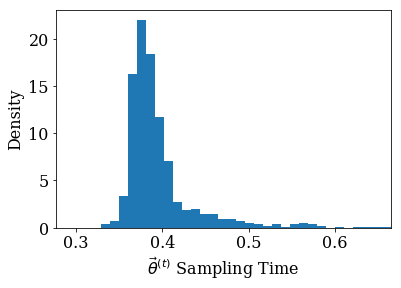

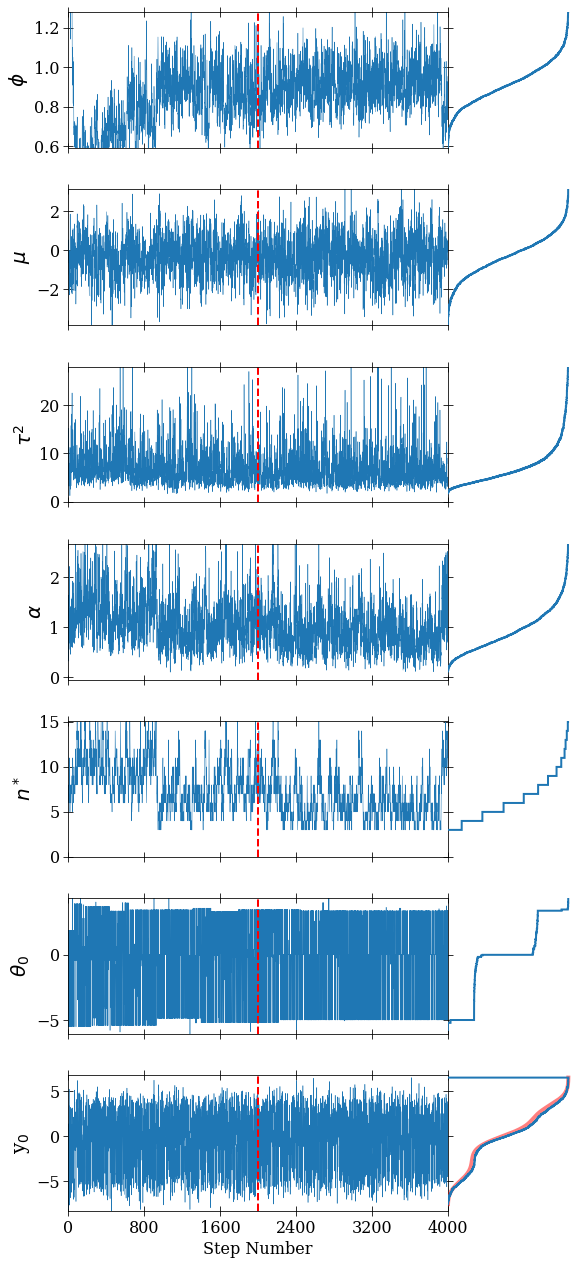

<Figure size 432x288 with 0 Axes>

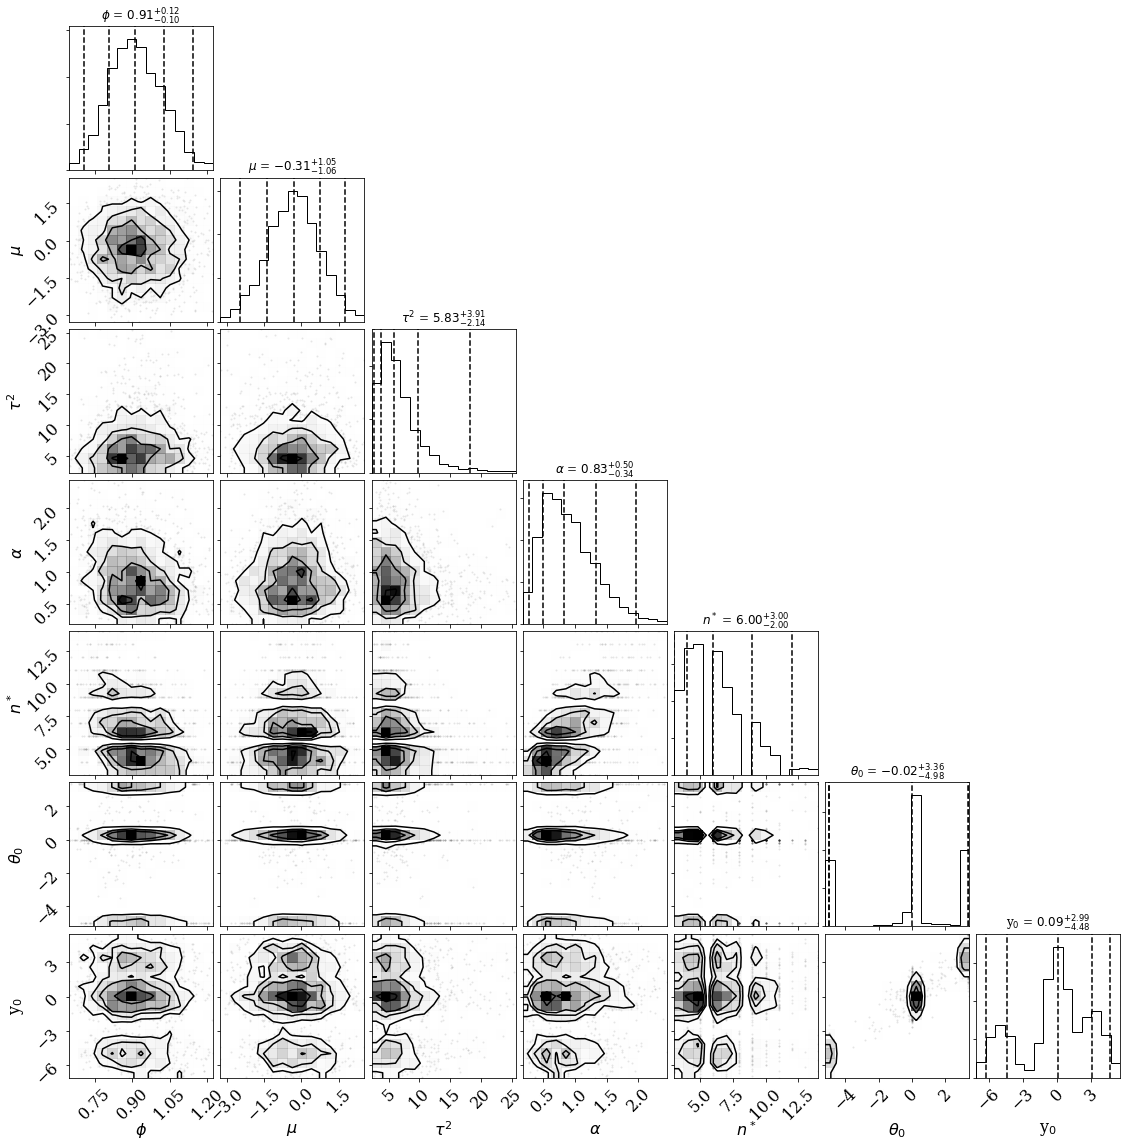

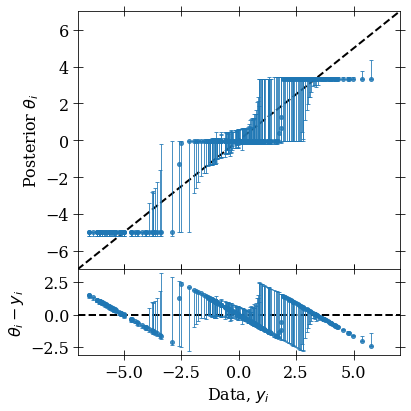

In [80]:
"""Plotting results of the standard gibbs approach""""

burnin = n_obs//2

plt.figure()
plt.hist(runtimes['standard gibbs'][burnin:],bins=100,density=True)
plt.xlabel(r'$\vec \theta^{(t)}$ Sampling Time');plt.ylabel('Density')
xbound = np.percentile(runtimes['standard gibbs'][burnin:],[99])
xlim = plt.xlim()
plt.xlim(max(xlim[0],0),xbound)
plt.show()

samples = np.copy(standard_gibbs_samples)

theta_vect_post = samples[:,:n]
phi_post = samples[:,n]
mu_post = samples[:,n+1]
tau2_post = samples[:,n+2]
alpha_post = samples[:,n+3]
theta0_post = samples[:,n+4]
y0_post = samples[:,n+5]
    
n_star_post = np.zeros(n_obs+1)

for i,theta_vect in enumerate(samples[:,:n]):
    n_star_post[i] = len(np.unique(theta_vect))

post_samples = np.array([phi_post,mu_post,tau2_post,alpha_post,\
                         n_star_post,theta0_post,y0_post]).T
        
    
def data_gen(y,pdf=True):
    if pdf:
        return 0.2*stats.norm(loc=-5,scale=1).pdf(y)+\
               0.5*stats.norm(loc=0,scale=1).pdf(y)+\
               0.3*stats.norm(loc=3.5,scale=1).pdf(y)
    else:
        return 0.2*stats.norm(loc=-5,scale=1).cdf(y)+\
               0.5*stats.norm(loc=0,scale=1).cdf(y)+\
               0.3*stats.norm(loc=3.5,scale=1).cdf(y)


dimLabels = [r'$\phi$',r'$\mu$',r'$\tau^2$',
             r'$\alpha$',r'$n^*$',r'$\theta_0$',r'y$_0$']

plt.figure(figsize=np.array([10,3*len(dimLabels)])*0.85)
gs = gridspec.GridSpec(len(dimLabels),2,width_ratios=[3,1],wspace=0)

step_nums = np.arange(0,n_obs+1)
for i in range(len(dimLabels)):
    ax = plt.subplot(gs[i, 0])    
#    plt.subplot(len(dimLabels),1,i+1)
#    ax = plt.gca()
    samps = post_samples[burnin+1:,i]
    bounds = np.percentile(samps,[0.5,99.5])
    spread = bounds[1]-bounds[0]
    
    ax.tick_params(axis='both',direction='inout',length=10,
                    bottom=True,left=True,top=True,right=True)
    plt.plot(step_nums,post_samples[:,i],lw=0.5)
    plt.xlim(step_nums[0],step_nums[-1])
    plt.xticks(np.arange(0, n_obs+1, n_obs//5).astype(int))
    if i == len(dimLabels)-1:
        plt.xlabel('Step Number')
    else:
        ax.xaxis.set_ticklabels([])
    plt.axvline(burnin,c='r',ls='--',lw=2)
    plt.ylabel(dimLabels[i],fontsize=20)
    ylim = plt.ylim(bounds[0]-0.1*spread,bounds[1]+0.1*spread)
#    if 'phi' in dimLabels[i]:
#        plt.ylim(ylim[0],2.5)
#    elif 'tau' in dimLabels[i]:
#        plt.ylim(ylim[0],40)
    if 'n^*' in dimLabels[i]:
        plt.ylim(0,ylim[1])
    ylim = plt.ylim()
    
    ax_hist = plt.subplot(gs[i, 1])  
    ax_hist.axis('off')
    if dimLabels[i] == r'y$_0$':
        ys = np.linspace(samps.min(),samps.max(),10000)
        cdf = data_gen(ys,pdf=False)
        plt.plot(cdf,ys,color='r',lw=4,zorder=-1000,alpha=0.5)
    plt.hist(samps,cumulative=True,lw=2,
             orientation='horizontal',density=True,
             bins=len(samps),histtype='step')
    plt.ylim(ylim)
    
plt.tight_layout()
#plt.savefig(f'{path}HW3_q2_traces_{mode}.png')
plt.show()

plt.figure()
corner.corner(post_samples[burnin:],labels=dimLabels,bins=15,
              quantiles=[0.025, 0.16, 0.5, 0.84, 0.975],show_titles=True,
              title_kwargs={"fontsize": 12},range=[0.99]*len(dimLabels))
#plt.savefig(f'{path}HW3_q2_cornerplot_{mode}.png')
plt.show()
    
plt.figure(figsize=[6,6])
gs = gridspec.GridSpec(2,1,height_ratios=[3,1],hspace=0)
theta_i_post = np.percentile(theta_vect_post[burnin+1:],[2.5,50,97.5],axis=0)
theta_i_post = np.array([theta_i_post[1],
                         theta_i_post[1]-theta_i_post[0],
                         theta_i_post[2]-theta_i_post[1]])
ax = plt.subplot(gs[0, 0])    
ax.tick_params(axis='both',direction='inout',length=10,
                bottom=True,left=True,top=True,right=True)
plt.ylabel(r'Posterior $\theta_i$')
plt.errorbar(data,theta_i_post[0],
             yerr=[theta_i_post[1],theta_i_post[2]],
             fmt='o',ms=4,alpha=0.8,
             elinewidth=1,capsize=2)
xlim = plt.xlim(-7,7)
ylim = plt.ylim(-7,7)
plt.plot(xlim,ylim,c='k',lw=2,zorder=-1000,ls='--')
plt.xlim(xlim);plt.ylim(ylim)
ax.xaxis.set_ticklabels([])

ax = plt.subplot(gs[1, 0])    
ax.tick_params(axis='both',direction='inout',length=10,
                bottom=True,left=True,top=True,right=True)
plt.axhline(0,c='k',lw=2,zorder=-1000,ls='--')
plt.errorbar(data,theta_i_post[0]-data,
             yerr=[theta_i_post[1],theta_i_post[2]],
             fmt='o',ms=4,alpha=0.8,
             elinewidth=1,capsize=2)
plt.xlim(xlim)
plt.xlabel(r'Data, $y_i$')
plt.ylabel(r'$\theta_i - y_i$')
plt.tight_layout()
#plt.savefig(f'{path}HW3_q2_post_theta_vect_{mode}.png')
plt.show()


In [6]:
"""Sampling using the No Gaps approach (MacEachern and Muller, 1998)"""

no_gaps_samples = np.zeros((n_obs+1,n+6))
#initial positions
alpha_val = alpha_prior.rvs(1)[0]
E_nstar = int(round(np.sum(alpha/(alpha+np.arange(n))),0))
theta_vect = np.sort(data)
theta_grouping = np.arange(0,n,n//E_nstar)
if n-theta_grouping[-1] > 0.5*n//E_nstar:
    theta_grouping = np.append(theta_grouping,n)
else:
    theta_grouping[-1] = n
for j in range(len(theta_grouping)-1):
    theta_vect[theta_grouping[j]:theta_grouping[j+1]] = \
               np.average(theta_vect[theta_grouping[j]:theta_grouping[j+1]])
theta_vect[np.argsort(data)] = theta_vect
phi_val = np.var(theta_vect-data)
mu_val = np.average(np.unique(theta_vect))
tau2_val = np.var(np.unique(theta_vect))

initial = np.zeros_like(no_gaps_samples[0])
initial[:n] = theta_vect
initial[n] = phi_val
initial[n+1] = mu_val
initial[n+2] = tau2_val
initial[n+3] = alpha_val
initial[n+4] = 0 #for posterior predictive distribution, theta_0
initial[n+5] = 0 #for posterior predictive distribution, y_0
no_gaps_samples[0] = initial
runtimes['no gaps'] = np.zeros(n_obs)

for ii,i in enumerate(tqdm(np.arange(n_obs)+1,total=n_obs)):
    previous = np.copy(no_gaps_samples[i-1])
    theta_vect = previous[:n]
    phi_val = previous[n]
    mu_val,tau2_val = previous[n+1],previous[n+2]
    alpha_val = previous[n+3]

    h_dist_var = (tau2_val*phi_val)/(tau2_val+phi_val)
    G_0 = stats.norm(loc=mu_val,scale=np.sqrt(tau2_val))
    q0_dist = stats.norm(loc=mu_val,scale=np.sqrt(phi_val+tau2_val))
    current = np.zeros_like(previous)

    runtime = time.time()
    #sample the theta vector one component at a time    

    unique_theta,s_j_vals,n_j_vals = np.unique(theta_vect,return_counts=True,return_inverse=True)
    
    for j in range(len(theta_vect)):
        unique_theta,s_j_vals,n_j_vals = np.unique(theta_vect,return_counts=True,return_inverse=True)
        n_star = len(n_j_vals)
        
        s_j = s_j_vals[j]
        
        if n_j_vals[s_j] == 1: #singleton
            nstar_minus = n_star-1
            singleton_prob = (nstar_minus-1)/nstar_minus
            if np.random.rand() < singleton_prob:
                continue #then don't change singleton
                
        n_j_vals_minus = np.copy(n_j_vals)
        n_j_vals_minus[s_j] -= 1
        
        poss_thetas = np.zeros(len(n_j_vals)+1)
        poss_thetas[1:] = unique_theta
        
        if n_j_vals[s_j] == 1: #singleton
            nstar_minus = n_star-1
            poss_thetas[0] = unique_theta[s_j]
        else: #not singleton
            nstar_minus = n_star
            poss_thetas[0] = G_0.rvs()
        
        weights = np.zeros(len(n_j_vals)+1)
        weights[1:] = n_j_vals_minus
        weights[0] = alpha_val/(nstar_minus+1)
        weights *= stats.norm(loc=poss_thetas,scale=np.sqrt(phi_val)).pdf(data[j])
        weights /= np.sum(weights)
        chosen_s_j = np.where(stats.multinomial(n=1,p=weights).rvs(1)[0] == 1)[0][0]
        if chosen_s_j == 0:
            if n_j_vals[s_j] == 1: #singleton
                continue #don't change
            else:
                #then added new value
                theta_vect[j] = poss_thetas[0]
        else:
            #then pick the corresponding unique theta value
            theta_vect[j] = unique_theta[chosen_s_j-1]
            
    unique_theta,s_j_vals,n_j_vals = np.unique(theta_vect,return_counts=True,return_inverse=True)
    n_star = len(n_j_vals)
    unique_theta_vals = np.zeros(n_star)

    for j in range(n_star):
        inds = (s_j_vals == j)
        n_j = np.sum(inds)
        new_mean = (mu_val*phi_val+tau2_val*np.sum(data[inds]))/(phi_val+n_j*tau2_val)
        new_sd = np.sqrt((tau2_val*phi_val)/(phi_val+n_j*tau2_val))

        unique_theta_vals[j] = stats.norm(loc=new_mean,scale=new_sd).rvs(1)[0]
    
    theta_vect = unique_theta_vals[s_j_vals]
    runtime = time.time()-runtime
    runtimes['no gaps'][ii] = runtime
    unique_theta,n_j_vals = np.unique(theta_vect,return_counts=True)
    n_star = len(unique_theta)
    
    a_phi_post = a_phi+0.5*n
    b_phi_post = b_phi+0.5*np.sum(np.power(data-theta_vect,2))
    phi_val = stats.invgamma(a=a_phi_post,
                                   scale=b_phi_post).rvs(1)[0]

    a_mu_post = (a_mu*tau2_val+b_mu*np.sum(unique_theta))/\
                            (tau2_val+n_star*b_mu)
    b_mu_post = (tau2_val*b_mu)/(tau2_val+n_star*b_mu)
    mu_val = stats.norm(loc=a_mu_post,scale=np.sqrt(b_mu_post)).rvs(1)[0]

    a_tau2_post = a_tau2+0.5*n_star
    b_tau2_post = b_tau2+0.5*np.sum(np.power(unique_theta-mu_val,2))
    tau2_val = stats.invgamma(a=a_tau2_post,
                                   scale=b_tau2_post).rvs(1)[0]

    #use the auxiliary variable eta to help draw alpha values
    #(eta | alpha, data) ~ Beta(alpha+1,n)
    #(alpha | eta, n_star) ~ mixture of gammas

    eta_val = stats.beta(a=alpha_val+1,b=n).rvs(1)[0]

    eps = (a_alpha+n_star-1)/(n*(b_alpha-np.log(eta_val))+a_alpha+n_star-1)
    gamma_choice = stats.binom(n=1,p=eps).rvs(1)[0]
    if gamma_choice == 0: #then draw from first gamma
        a_alpha_post = a_alpha+n_star
    else: #then draw from 2nd gamma
        a_alpha_post = a_alpha+n_star-1
    b_alpha_post = b_alpha-np.log(eta_val)

    alpha_val = stats.gamma(a=a_alpha_post,scale=1/b_alpha_post).rvs(1)[0]

    #posterior predictive:
    post_predic_w = np.zeros(n_star+1)
    post_predic_w[0] = alpha_val/(alpha_val+n)
    post_predic_w[1:] = n_j_vals/(alpha_val+n)
    post_predic_w /= np.sum(post_predic_w)
    chosen_theta = np.where(stats.multinomial(n=1,
                                p=post_predic_w).rvs(1)[0] == 1)[0][0]
    if chosen_theta == 0:
        #new draw from h
        theta_0 = stats.norm(loc=mu_val,scale=np.sqrt(tau2_val)).rvs(1)[0]
    else:
        #then pick the corresponding unique theta value
        theta_0 = unique_theta[chosen_theta-1]
    #draw from kernel
    y_0 = stats.norm(loc=theta_0,scale=np.sqrt(phi_val)).rvs(1)[0]

    current[:n] = theta_vect
    current[n] = phi_val
    current[n+1] = mu_val
    current[n+2] = tau2_val
    current[n+3] = alpha_val
    current[n+4] = theta_0    
    current[n+5] = y_0    
    no_gaps_samples[i] = current

100%|██████████| 4000/4000 [17:21<00:00,  4.08it/s]


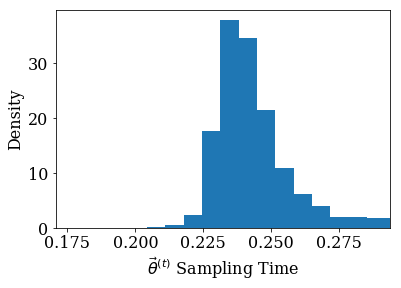

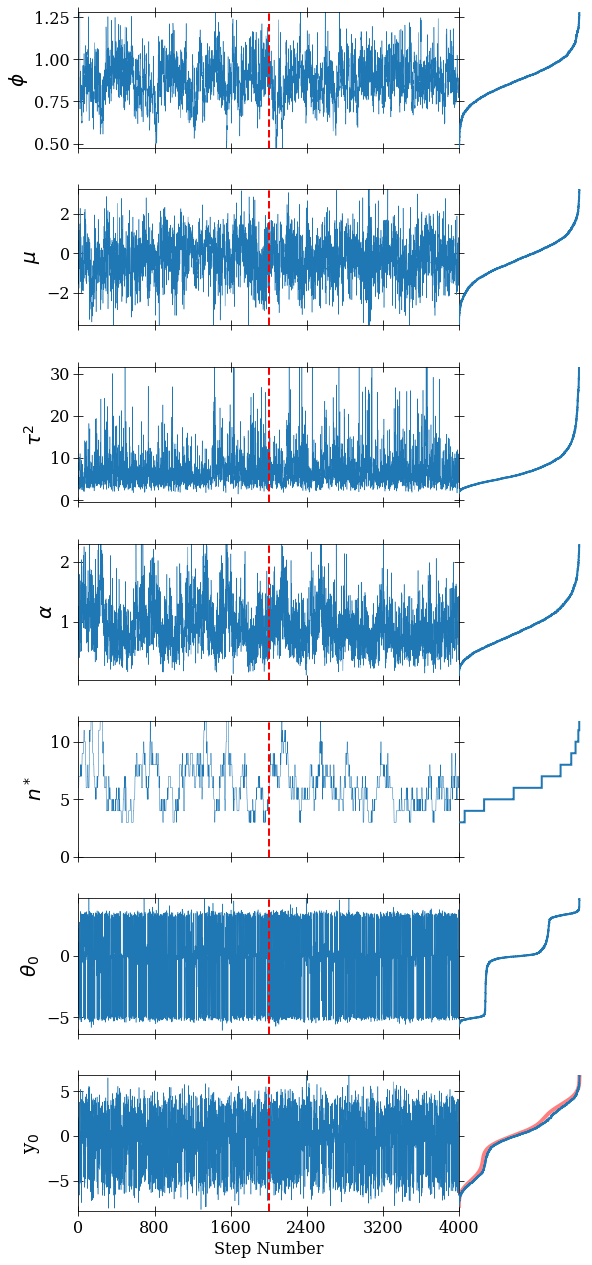

<Figure size 432x288 with 0 Axes>

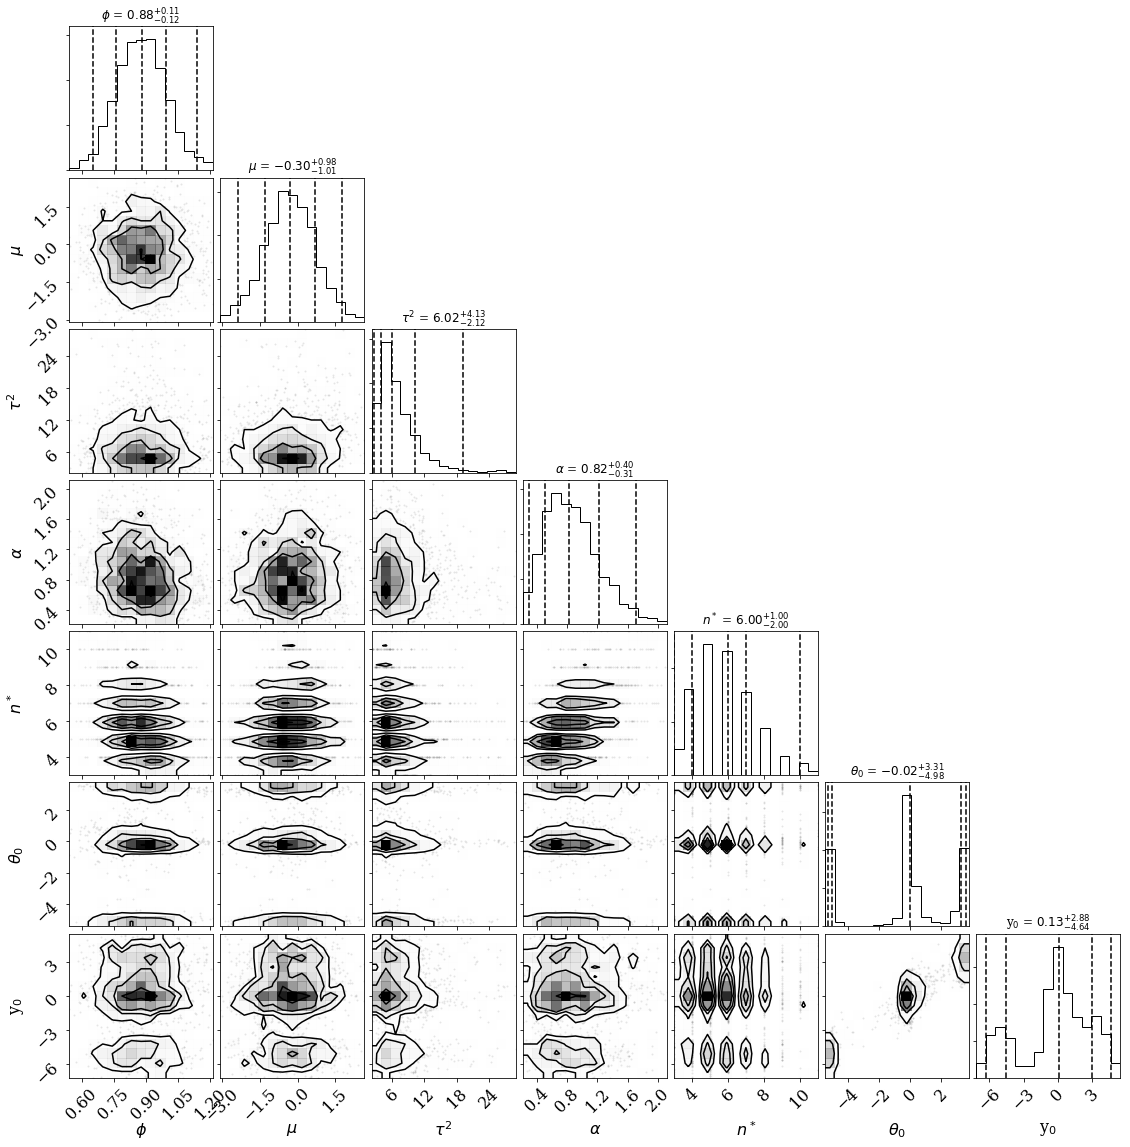

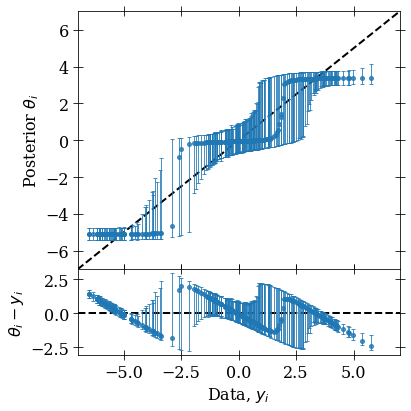

In [79]:
"""Plotting results of the No Gaps approach""""

burnin = n_obs//2

plt.figure()
plt.hist(runtimes['no gaps'][burnin:],bins=100,density=True)
plt.xlabel(r'$\vec \theta^{(t)}$ Sampling Time');plt.ylabel('Density')
xbound = np.percentile(runtimes['no gaps'][burnin:],[95])
xlim = plt.xlim()
plt.xlim(max(xlim[0],0),xbound)
plt.show()

samples = np.copy(no_gaps_samples)

theta_vect_post = samples[:,:n]
phi_post = samples[:,n]
mu_post = samples[:,n+1]
tau2_post = samples[:,n+2]
alpha_post = samples[:,n+3]
theta0_post = samples[:,n+4]
y0_post = samples[:,n+5]
    
n_star_post = np.zeros(n_obs+1)

for i,theta_vect in enumerate(samples[:,:n]):
    n_star_post[i] = len(np.unique(theta_vect))

post_samples = np.array([phi_post,mu_post,tau2_post,alpha_post,\
                         n_star_post,theta0_post,y0_post]).T
        
    
def data_gen(y,pdf=True):
    if pdf:
        return 0.2*stats.norm(loc=-5,scale=1).pdf(y)+\
               0.5*stats.norm(loc=0,scale=1).pdf(y)+\
               0.3*stats.norm(loc=3.5,scale=1).pdf(y)
    else:
        return 0.2*stats.norm(loc=-5,scale=1).cdf(y)+\
               0.5*stats.norm(loc=0,scale=1).cdf(y)+\
               0.3*stats.norm(loc=3.5,scale=1).cdf(y)

dimLabels = [r'$\phi$',r'$\mu$',r'$\tau^2$',
             r'$\alpha$',r'$n^*$',r'$\theta_0$',r'y$_0$']

plt.figure(figsize=np.array([10,3*len(dimLabels)])*0.85)
gs = gridspec.GridSpec(len(dimLabels),2,width_ratios=[3,1],wspace=0)

step_nums = np.arange(0,n_obs+1)
for i in range(len(dimLabels)):
    ax = plt.subplot(gs[i, 0])    
#    plt.subplot(len(dimLabels),1,i+1)
#    ax = plt.gca()
    samps = post_samples[burnin+1:,i]
    bounds = np.percentile(samps,[0.5,99.5])
    spread = bounds[1]-bounds[0]
    
    ax.tick_params(axis='both',direction='inout',length=10,
                    bottom=True,left=True,top=True,right=True)
    plt.plot(step_nums,post_samples[:,i],lw=0.5)
    plt.xlim(step_nums[0],step_nums[-1])
    plt.xticks(np.arange(0, n_obs+1, n_obs//5).astype(int))
    if i == len(dimLabels)-1:
        plt.xlabel('Step Number')
    else:
        ax.xaxis.set_ticklabels([])
    plt.axvline(burnin,c='r',ls='--',lw=2)
    plt.ylabel(dimLabels[i],fontsize=20)
    ylim = plt.ylim(bounds[0]-0.1*spread,bounds[1]+0.1*spread)
#    if 'phi' in dimLabels[i]:
#        plt.ylim(ylim[0],2.5)
#    elif 'tau' in dimLabels[i]:
#        plt.ylim(ylim[0],40)
    if 'n^*' in dimLabels[i]:
        plt.ylim(0,ylim[1])
    ylim = plt.ylim()
    
    ax_hist = plt.subplot(gs[i, 1])  
    ax_hist.axis('off')
    if dimLabels[i] == r'y$_0$':
        ys = np.linspace(samps.min(),samps.max(),10000)
        cdf = data_gen(ys,pdf=False)
        plt.plot(cdf,ys,color='r',lw=4,zorder=-1000,alpha=0.5)
    plt.hist(samps,cumulative=True,lw=2,
             orientation='horizontal',density=True,
             bins=len(samps),histtype='step')
    plt.ylim(ylim)
    
plt.tight_layout()
#plt.savefig(f'{path}HW3_q2_traces_{mode}.png')
plt.show()

plt.figure()
corner.corner(post_samples[burnin:],labels=dimLabels,bins=15,
              quantiles=[0.025, 0.16, 0.5, 0.84, 0.975],show_titles=True,
              title_kwargs={"fontsize": 12},range=[0.99]*len(dimLabels))
#plt.savefig(f'{path}HW3_q2_cornerplot_{mode}.png')
plt.show()
    
plt.figure(figsize=[6,6])
gs = gridspec.GridSpec(2,1,height_ratios=[3,1],hspace=0)
theta_i_post = np.percentile(theta_vect_post[burnin+1:],[2.5,50,97.5],axis=0)
theta_i_post = np.array([theta_i_post[1],
                         theta_i_post[1]-theta_i_post[0],
                         theta_i_post[2]-theta_i_post[1]])
ax = plt.subplot(gs[0, 0])    
ax.tick_params(axis='both',direction='inout',length=10,
                bottom=True,left=True,top=True,right=True)
plt.ylabel(r'Posterior $\theta_i$')
plt.errorbar(data,theta_i_post[0],
             yerr=[theta_i_post[1],theta_i_post[2]],
             fmt='o',ms=4,alpha=0.8,
             elinewidth=1,capsize=2)
xlim = plt.xlim(-7,7)
ylim = plt.ylim(-7,7)
plt.plot(xlim,ylim,c='k',lw=2,zorder=-1000,ls='--')
plt.xlim(xlim);plt.ylim(ylim)
ax.xaxis.set_ticklabels([])

ax = plt.subplot(gs[1, 0])    
ax.tick_params(axis='both',direction='inout',length=10,
                bottom=True,left=True,top=True,right=True)
plt.axhline(0,c='k',lw=2,zorder=-1000,ls='--')
plt.errorbar(data,theta_i_post[0]-data,
             yerr=[theta_i_post[1],theta_i_post[2]],
             fmt='o',ms=4,alpha=0.8,
             elinewidth=1,capsize=2)
plt.xlim(xlim)
plt.xlabel(r'Data, $y_i$')
plt.ylabel(r'$\theta_i - y_i$')
plt.tight_layout()
#plt.savefig(f'{path}HW3_q2_post_theta_vect_{mode}.png')
plt.show()


In [8]:
"""Sampling using the No Gaps + Auxiliary approach (Neal 2000, algorithm 8)"""

m_param = 3 #the number of auxiliary

no_gaps_aux_samples = np.zeros((n_obs+1,n+6))
#initial positions
alpha_val = alpha_prior.rvs(1)[0]
E_nstar = int(round(np.sum(alpha/(alpha+np.arange(n))),0))
theta_vect = np.sort(data)
theta_grouping = np.arange(0,n,n//E_nstar)
if n-theta_grouping[-1] > 0.5*n//E_nstar:
    theta_grouping = np.append(theta_grouping,n)
else:
    theta_grouping[-1] = n
for j in range(len(theta_grouping)-1):
    theta_vect[theta_grouping[j]:theta_grouping[j+1]] = \
               np.average(theta_vect[theta_grouping[j]:theta_grouping[j+1]])
theta_vect[np.argsort(data)] = theta_vect
phi_val = np.var(theta_vect-data)
mu_val = np.average(np.unique(theta_vect))
tau2_val = np.var(np.unique(theta_vect))

initial = np.zeros_like(no_gaps_aux_samples[0])
initial[:n] = theta_vect
initial[n] = phi_val
initial[n+1] = mu_val
initial[n+2] = tau2_val
initial[n+3] = alpha_val
initial[n+4] = 0 #for posterior predictive distribution, theta_0
initial[n+5] = 0 #for posterior predictive distribution, y_0
no_gaps_aux_samples[0] = initial
runtimes['no gaps auxiliary'] = np.zeros(n_obs)

for ii,i in enumerate(tqdm(np.arange(n_obs)+1,total=n_obs)):
    previous = np.copy(no_gaps_aux_samples[i-1])
    theta_vect = previous[:n]
    phi_val = previous[n]
    mu_val,tau2_val = previous[n+1],previous[n+2]
    alpha_val = previous[n+3]

    h_dist_var = (tau2_val*phi_val)/(tau2_val+phi_val)
    G_0 = stats.norm(loc=mu_val,scale=np.sqrt(tau2_val))
    q0_dist = stats.norm(loc=mu_val,scale=np.sqrt(phi_val+tau2_val))
    current = np.zeros_like(previous)

    runtime = time.time()
    
    for j in range(len(theta_vect)):
        unique_theta,s_j_vals,n_j_vals = np.unique(theta_vect,return_counts=True,return_inverse=True)
        n_star = len(n_j_vals)
        s_j = s_j_vals[j]
                
        n_j_vals_minus = np.copy(n_j_vals)
        n_j_vals_minus[s_j] -= 1
        
        poss_thetas = np.zeros(len(n_j_vals)+m_param)
        poss_thetas[:len(n_j_vals)] = unique_theta
        
        if n_j_vals[s_j] == 1: #singleton
            nstar_minus = n_star-1
            poss_thetas[len(n_j_vals)] = unique_theta[s_j]
            poss_thetas[len(n_j_vals)+1:] = G_0.rvs(m_param-1)
        else: #not singleton
            nstar_minus = n_star
            poss_thetas[len(n_j_vals):] = G_0.rvs(m_param)
                    
        weights = np.zeros(len(n_j_vals)+m_param)
        weights[:len(n_j_vals)] = n_j_vals_minus/(n-1+alpha_val)
        weights[len(n_j_vals):] = (alpha_val/m_param)/(n-1+alpha_val)
        weights *= stats.norm(loc=poss_thetas,scale=np.sqrt(phi_val)).pdf(data[j])
        weights /= np.sum(weights)
        chosen_s_j = np.where(stats.multinomial(n=1,p=weights).rvs(1)[0] == 1)[0][0]
        if (n_j_vals[s_j] == 1) and (chosen_s_j == len(n_j_vals)): #singleton
            continue #don't change
        else:
            theta_vect[j] = poss_thetas[chosen_s_j]
            
    unique_theta,s_j_vals,n_j_vals = np.unique(theta_vect,return_counts=True,return_inverse=True)
    n_star = len(n_j_vals)
    unique_theta_vals = np.zeros(n_star)

    for j in range(n_star):
        inds = (s_j_vals == j)
        n_j = np.sum(inds)
        new_mean = (mu_val*phi_val+tau2_val*np.sum(data[inds]))/(phi_val+n_j*tau2_val)
        new_sd = np.sqrt((tau2_val*phi_val)/(phi_val+n_j*tau2_val))

        unique_theta_vals[j] = stats.norm(loc=new_mean,scale=new_sd).rvs(1)[0]
    
    theta_vect = unique_theta_vals[s_j_vals]
    runtime = time.time()-runtime
    runtimes['no gaps auxiliary'][ii] = runtime
    unique_theta,n_j_vals = np.unique(theta_vect,return_counts=True)
    n_star = len(unique_theta)
    
    a_phi_post = a_phi+0.5*n
    b_phi_post = b_phi+0.5*np.sum(np.power(data-theta_vect,2))
    phi_val = stats.invgamma(a=a_phi_post,
                                   scale=b_phi_post).rvs(1)[0]

    a_mu_post = (a_mu*tau2_val+b_mu*np.sum(unique_theta))/\
                            (tau2_val+n_star*b_mu)
    b_mu_post = (tau2_val*b_mu)/(tau2_val+n_star*b_mu)
    mu_val = stats.norm(loc=a_mu_post,scale=np.sqrt(b_mu_post)).rvs(1)[0]

    a_tau2_post = a_tau2+0.5*n_star
    b_tau2_post = b_tau2+0.5*np.sum(np.power(unique_theta-mu_val,2))
    tau2_val = stats.invgamma(a=a_tau2_post,
                                   scale=b_tau2_post).rvs(1)[0]

    #use the auxiliary variable eta to help draw alpha values
    #(eta | alpha, data) ~ Beta(alpha+1,n)
    #(alpha | eta, n_star) ~ mixture of gammas

    eta_val = stats.beta(a=alpha_val+1,b=n).rvs(1)[0]

    eps = (a_alpha+n_star-1)/(n*(b_alpha-np.log(eta_val))+a_alpha+n_star-1)
    gamma_choice = stats.binom(n=1,p=eps).rvs(1)[0]
    if gamma_choice == 0: #then draw from first gamma
        a_alpha_post = a_alpha+n_star
    else: #then draw from 2nd gamma
        a_alpha_post = a_alpha+n_star-1
    b_alpha_post = b_alpha-np.log(eta_val)

    alpha_val = stats.gamma(a=a_alpha_post,scale=1/b_alpha_post).rvs(1)[0]

    #posterior predictive:
    post_predic_w = np.zeros(n_star+1)
    post_predic_w[0] = alpha_val/(alpha_val+n)
    post_predic_w[1:] = n_j_vals/(alpha_val+n)
    post_predic_w /= np.sum(post_predic_w)
    chosen_theta = np.where(stats.multinomial(n=1,
                                p=post_predic_w).rvs(1)[0] == 1)[0][0]
    if chosen_theta == 0:
        #new draw from h
        theta_0 = stats.norm(loc=mu_val,scale=np.sqrt(tau2_val)).rvs(1)[0]
    else:
        #then pick the corresponding unique theta value
        theta_0 = unique_theta[chosen_theta-1]
    #draw from kernel
    y_0 = stats.norm(loc=theta_0,scale=np.sqrt(phi_val)).rvs(1)[0]

    current[:n] = theta_vect
    current[n] = phi_val
    current[n+1] = mu_val
    current[n+2] = tau2_val
    current[n+3] = alpha_val
    current[n+4] = theta_0    
    current[n+5] = y_0    
    no_gaps_aux_samples[i] = current

100%|██████████| 4000/4000 [16:45<00:00,  4.75it/s]


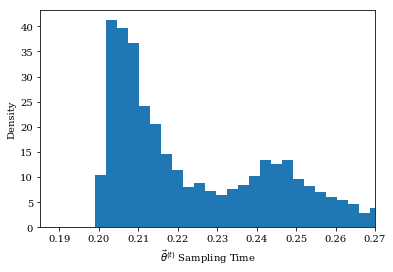

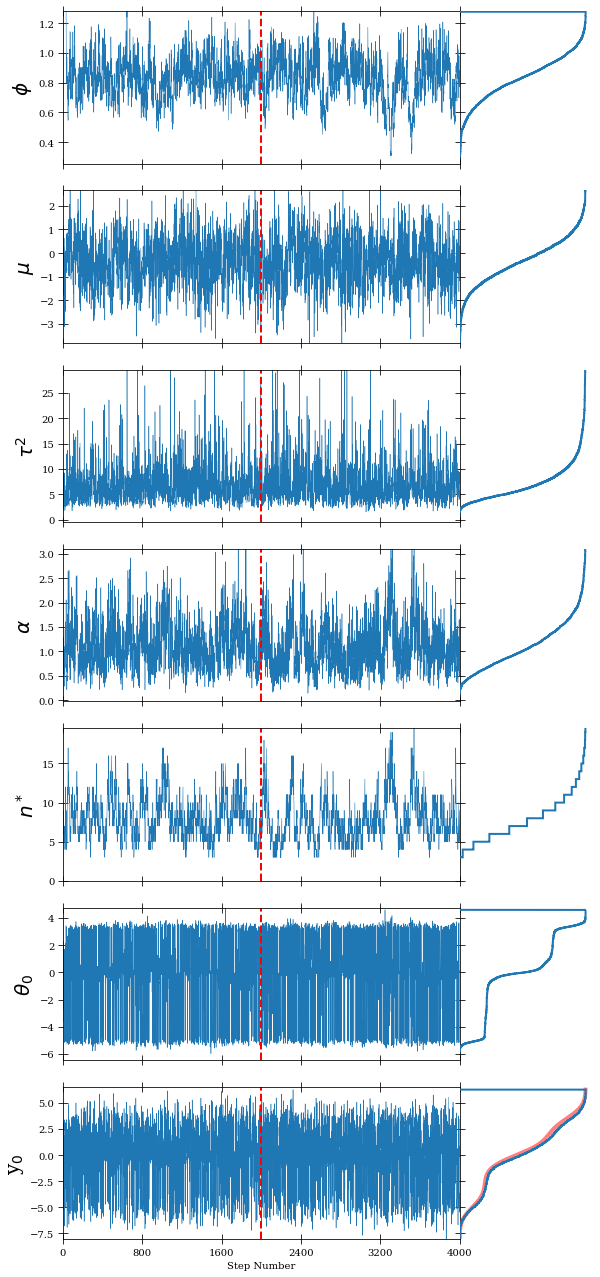

<Figure size 432x288 with 0 Axes>

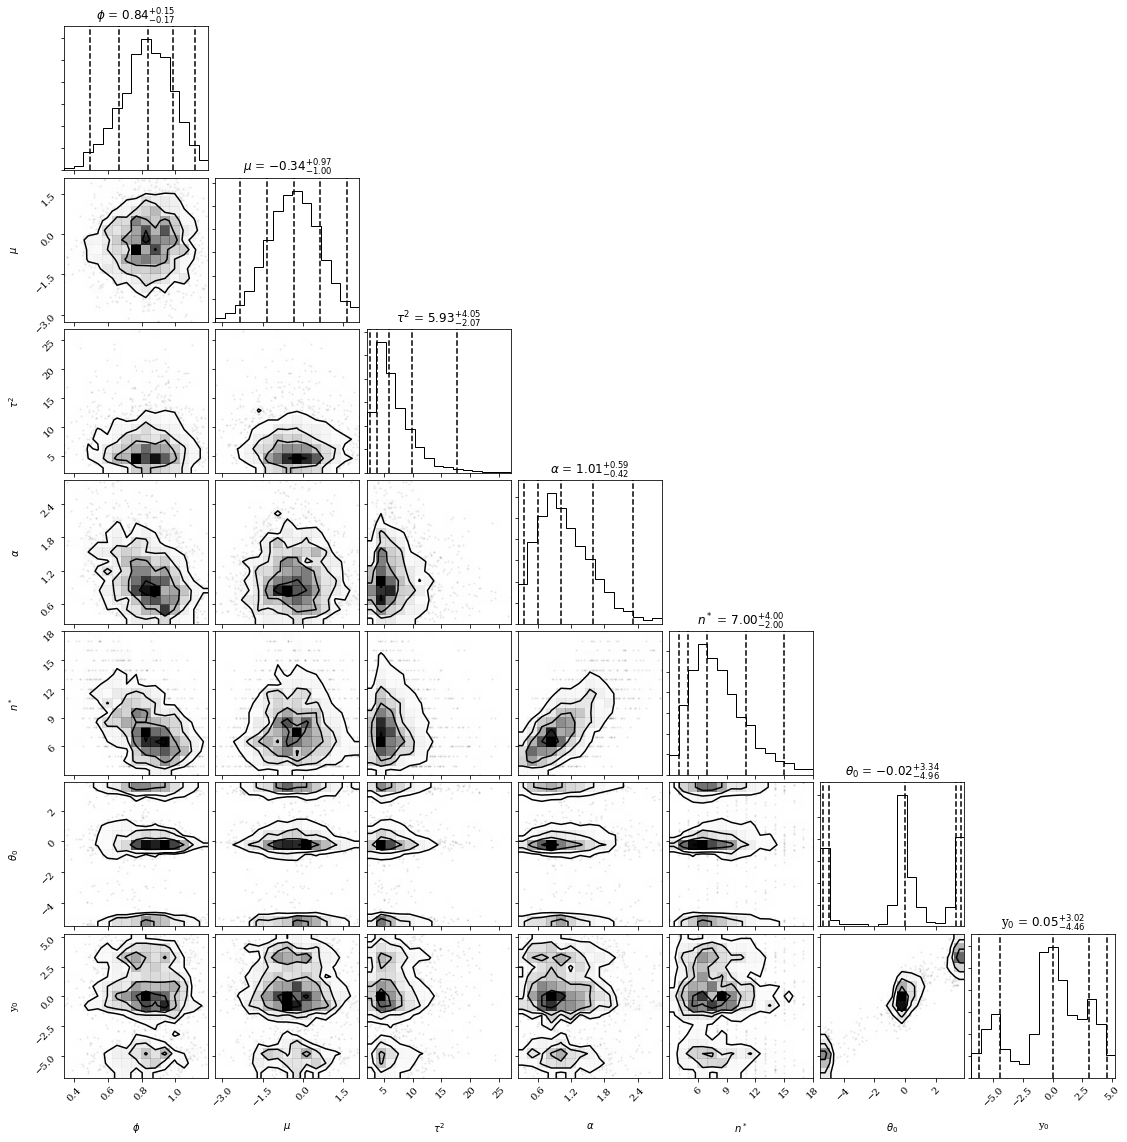

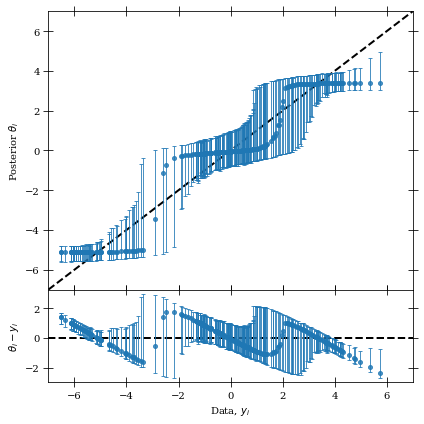

In [9]:
"""Plotting the results of the No Gaps + Auxiliary approach"""

burnin = n_obs//2

plt.figure()
plt.hist(runtimes['no gaps auxiliary'][burnin:],bins=100,density=True)
plt.xlabel(r'$\vec \theta^{(t)}$ Sampling Time');plt.ylabel('Density')
xbound = np.percentile(runtimes['no gaps auxiliary'][burnin:],[95])
xlim = plt.xlim()
plt.xlim(max(xlim[0],0),xbound)
plt.show()

samples = np.copy(no_gaps_aux_samples)

theta_vect_post = samples[:,:n]
phi_post = samples[:,n]
mu_post = samples[:,n+1]
tau2_post = samples[:,n+2]
alpha_post = samples[:,n+3]
theta0_post = samples[:,n+4]
y0_post = samples[:,n+5]
    
n_star_post = np.zeros(n_obs+1)

for i,theta_vect in enumerate(samples[:,:n]):
    n_star_post[i] = len(np.unique(theta_vect))

post_samples = np.array([phi_post,mu_post,tau2_post,alpha_post,\
                         n_star_post,theta0_post,y0_post]).T
        
    
def data_gen(y,pdf=True):
    if pdf:
        return 0.2*stats.norm(loc=-5,scale=1).pdf(y)+\
               0.5*stats.norm(loc=0,scale=1).pdf(y)+\
               0.3*stats.norm(loc=3.5,scale=1).pdf(y)
    else:
        return 0.2*stats.norm(loc=-5,scale=1).cdf(y)+\
               0.5*stats.norm(loc=0,scale=1).cdf(y)+\
               0.3*stats.norm(loc=3.5,scale=1).cdf(y)

dimLabels = [r'$\phi$',r'$\mu$',r'$\tau^2$',
             r'$\alpha$',r'$n^*$',r'$\theta_0$',r'y$_0$']

plt.figure(figsize=np.array([10,3*len(dimLabels)])*0.85)
gs = gridspec.GridSpec(len(dimLabels),2,width_ratios=[3,1],wspace=0)

step_nums = np.arange(0,n_obs+1)
for i in range(len(dimLabels)):
    ax = plt.subplot(gs[i, 0])    
#    plt.subplot(len(dimLabels),1,i+1)
#    ax = plt.gca()
    samps = post_samples[burnin+1:,i]
    bounds = np.percentile(samps,[0.5,99.5])
    spread = bounds[1]-bounds[0]
    
    ax.tick_params(axis='both',direction='inout',length=10,
                    bottom=True,left=True,top=True,right=True)
    plt.plot(step_nums,post_samples[:,i],lw=0.5)
    plt.xlim(step_nums[0],step_nums[-1])
    plt.xticks(np.arange(0, n_obs+1, n_obs//5).astype(int))
    if i == len(dimLabels)-1:
        plt.xlabel('Step Number')
    else:
        ax.xaxis.set_ticklabels([])
    plt.axvline(burnin,c='r',ls='--',lw=2)
    plt.ylabel(dimLabels[i],fontsize=20)
    ylim = plt.ylim(bounds[0]-0.1*spread,bounds[1]+0.1*spread)
#    if 'phi' in dimLabels[i]:
#        plt.ylim(ylim[0],2.5)
#    elif 'tau' in dimLabels[i]:
#        plt.ylim(ylim[0],40)
    if 'n^*' in dimLabels[i]:
        plt.ylim(0,ylim[1])
    ylim = plt.ylim()
    
    ax_hist = plt.subplot(gs[i, 1])  
    ax_hist.axis('off')
    if dimLabels[i] == r'y$_0$':
        ys = np.linspace(samps.min(),samps.max(),10000)
        cdf = data_gen(ys,pdf=False)
        plt.plot(cdf,ys,color='r',lw=4,zorder=-1000,alpha=0.5)
    plt.hist(samps,cumulative=True,lw=2,
             orientation='horizontal',density=True,
             bins=len(samps),histtype='step')
    plt.ylim(ylim)
    
plt.tight_layout()
#plt.savefig(f'{path}HW3_q2_traces_{mode}.png')
plt.show()

plt.figure()
corner.corner(post_samples[burnin:],labels=dimLabels,bins=15,
              quantiles=[0.025, 0.16, 0.5, 0.84, 0.975],show_titles=True,
              title_kwargs={"fontsize": 12},range=[0.99]*len(dimLabels))
#plt.savefig(f'{path}HW3_q2_cornerplot_{mode}.png')
plt.show()
    
plt.figure(figsize=[6,6])
gs = gridspec.GridSpec(2,1,height_ratios=[3,1],hspace=0)
theta_i_post = np.percentile(theta_vect_post[burnin+1:],[2.5,50,97.5],axis=0)
theta_i_post = np.array([theta_i_post[1],
                         theta_i_post[1]-theta_i_post[0],
                         theta_i_post[2]-theta_i_post[1]])
ax = plt.subplot(gs[0, 0])    
ax.tick_params(axis='both',direction='inout',length=10,
                bottom=True,left=True,top=True,right=True)
plt.ylabel(r'Posterior $\theta_i$')
plt.errorbar(data,theta_i_post[0],
             yerr=[theta_i_post[1],theta_i_post[2]],
             fmt='o',ms=4,alpha=0.8,
             elinewidth=1,capsize=2)
xlim = plt.xlim(-7,7)
ylim = plt.ylim(-7,7)
plt.plot(xlim,ylim,c='k',lw=2,zorder=-1000,ls='--')
plt.xlim(xlim);plt.ylim(ylim)
ax.xaxis.set_ticklabels([])

ax = plt.subplot(gs[1, 0])    
ax.tick_params(axis='both',direction='inout',length=10,
                bottom=True,left=True,top=True,right=True)
plt.axhline(0,c='k',lw=2,zorder=-1000,ls='--')
plt.errorbar(data,theta_i_post[0]-data,
             yerr=[theta_i_post[1],theta_i_post[2]],
             fmt='o',ms=4,alpha=0.8,
             elinewidth=1,capsize=2)
plt.xlim(xlim)
plt.xlabel(r'Data, $y_i$')
plt.ylabel(r'$\theta_i - y_i$')
plt.tight_layout()
#plt.savefig(f'{path}HW3_q2_post_theta_vect_{mode}.png')
plt.show()


In [11]:
"""Sampling using the Metropolis-Hastings approach (Neal 2000, algorithm 7)"""

mh_samples = np.zeros((n_obs+1,n+6))
#initial positions
alpha_val = alpha_prior.rvs(1)[0]
E_nstar = int(round(np.sum(alpha/(alpha+np.arange(n))),0))
theta_vect = np.sort(data)
theta_grouping = np.arange(0,n,n//E_nstar)
if n-theta_grouping[-1] > 0.5*n//E_nstar:
    theta_grouping = np.append(theta_grouping,n)
else:
    theta_grouping[-1] = n
for j in range(len(theta_grouping)-1):
    theta_vect[theta_grouping[j]:theta_grouping[j+1]] = \
               np.average(theta_vect[theta_grouping[j]:theta_grouping[j+1]])
theta_vect[np.argsort(data)] = theta_vect
phi_val = np.var(theta_vect-data)
mu_val = np.average(np.unique(theta_vect))
tau2_val = np.var(np.unique(theta_vect))

initial = np.zeros_like(mh_samples[0])
initial[:n] = theta_vect
initial[n] = phi_val
initial[n+1] = mu_val
initial[n+2] = tau2_val
initial[n+3] = alpha_val
initial[n+4] = 0 #for posterior predictive distribution, theta_0
initial[n+5] = 0 #for posterior predictive distribution, y_0
mh_samples[0] = initial
runtimes['MH'] = np.zeros(n_obs)

for ii,i in enumerate(tqdm(np.arange(n_obs)+1,total=n_obs)):
    previous = np.copy(mh_samples[i-1])
    theta_vect = previous[:n]
    phi_val = previous[n]
    mu_val,tau2_val = previous[n+1],previous[n+2]
    alpha_val = previous[n+3]

    h_dist_var = (tau2_val*phi_val)/(tau2_val+phi_val)
    G_0 = stats.norm(loc=mu_val,scale=np.sqrt(tau2_val))
    q0_dist = stats.norm(loc=mu_val,scale=np.sqrt(phi_val+tau2_val))
    current = np.zeros_like(previous)

    runtime = time.time()
    #sample the theta vector one component at a time        
    for j in range(len(theta_vect)):
        unique_theta,s_j_vals,n_j_vals = np.unique(theta_vect,return_counts=True,return_inverse=True)
        n_star = len(n_j_vals)
        
        s_j = s_j_vals[j]
        n_j_vals_minus = np.copy(n_j_vals)
        n_j_vals_minus[s_j] -= 1
        
        if n_j_vals[s_j] == 1: #singleton
            weights = np.zeros(len(unique_theta))
            weights = n_j_vals_minus/(n-1)
            weights /= np.sum(weights)
            
            chosen_s_j = np.where(stats.multinomial(n=1,p=weights).rvs(1)[0] == 1)[0][0]
            
            new_theta = unique_theta[chosen_s_j]
            current_theta = theta_vect[j]
            new_kernel = stats.norm(loc=new_theta,scale=np.sqrt(phi_val)).pdf(data[j])            
            current_kernel = stats.norm(loc=current_theta,scale=np.sqrt(phi_val)).pdf(data[j])            
            acpt_prob = min(1,((n-1)/(alpha_val))*((new_kernel)/(current_kernel)))
            if np.random.rand() < acpt_prob:
                #accept the proposal
                theta_vect[j] = new_theta
            else:
                #reject the proposal
                continue
        else:
            new_theta = G_0.rvs()
            current_theta = theta_vect[j]
            new_kernel = stats.norm(loc=new_theta,scale=np.sqrt(phi_val)).pdf(data[j])            
            current_kernel = stats.norm(loc=current_theta,scale=np.sqrt(phi_val)).pdf(data[j])            
            acpt_prob = min(1,((alpha_val)/(n-1))*((new_kernel)/(current_kernel)))
            if np.random.rand() < acpt_prob:
                #accept the proposal
                theta_vect[j] = new_theta
            else:
                #reject the proposal
                continue
                
    for j in range(len(theta_vect)):
        unique_theta,s_j_vals,n_j_vals = np.unique(theta_vect,return_counts=True,return_inverse=True)
        n_star = len(n_j_vals)
        
        s_j = s_j_vals[j]
        n_j_vals_minus = np.copy(n_j_vals)
        n_j_vals_minus[s_j] -= 1
        
        if n_j_vals[s_j] == 1: #singleton
            continue
        else:
            weights = np.zeros(len(unique_theta))
            weights = (n_j_vals_minus/(n-1))*stats.norm(loc=unique_theta,scale=np.sqrt(phi_val)).pdf(data[j])
            weights /= np.sum(weights)
            
            chosen_s_j = np.where(stats.multinomial(n=1,p=weights).rvs(1)[0] == 1)[0][0]            
            theta_vect[j] = unique_theta[chosen_s_j]
            
    unique_theta,s_j_vals,n_j_vals = np.unique(theta_vect,return_counts=True,return_inverse=True)
    n_star = len(n_j_vals)
    unique_theta_vals = np.zeros(n_star)

    for j in range(n_star):
        inds = (s_j_vals == j)
        n_j = np.sum(inds)
        new_mean = (mu_val*phi_val+tau2_val*np.sum(data[inds]))/(phi_val+n_j*tau2_val)
        new_sd = np.sqrt((tau2_val*phi_val)/(phi_val+n_j*tau2_val))

        unique_theta_vals[j] = stats.norm(loc=new_mean,scale=new_sd).rvs(1)[0]
    
    theta_vect = unique_theta_vals[s_j_vals]
    runtime = time.time()-runtime
    runtimes['MH'][ii] = runtime
    unique_theta,n_j_vals = np.unique(theta_vect,return_counts=True)
    n_star = len(unique_theta)
    
    a_phi_post = a_phi+0.5*n
    b_phi_post = b_phi+0.5*np.sum(np.power(data-theta_vect,2))
    phi_val = stats.invgamma(a=a_phi_post,
                                   scale=b_phi_post).rvs(1)[0]

    a_mu_post = (a_mu*tau2_val+b_mu*np.sum(unique_theta))/\
                            (tau2_val+n_star*b_mu)
    b_mu_post = (tau2_val*b_mu)/(tau2_val+n_star*b_mu)
    mu_val = stats.norm(loc=a_mu_post,scale=np.sqrt(b_mu_post)).rvs(1)[0]

    a_tau2_post = a_tau2+0.5*n_star
    b_tau2_post = b_tau2+0.5*np.sum(np.power(unique_theta-mu_val,2))
    tau2_val = stats.invgamma(a=a_tau2_post,
                                   scale=b_tau2_post).rvs(1)[0]

    #use the auxiliary variable eta to help draw alpha values
    #(eta | alpha, data) ~ Beta(alpha+1,n)
    #(alpha | eta, n_star) ~ mixture of gammas

    eta_val = stats.beta(a=alpha_val+1,b=n).rvs(1)[0]

    eps = (a_alpha+n_star-1)/(n*(b_alpha-np.log(eta_val))+a_alpha+n_star-1)
    gamma_choice = stats.binom(n=1,p=eps).rvs(1)[0]
    if gamma_choice == 0: #then draw from first gamma
        a_alpha_post = a_alpha+n_star
    else: #then draw from 2nd gamma
        a_alpha_post = a_alpha+n_star-1
    b_alpha_post = b_alpha-np.log(eta_val)

    alpha_val = stats.gamma(a=a_alpha_post,scale=1/b_alpha_post).rvs(1)[0]

    #posterior predictive:
    post_predic_w = np.zeros(n_star+1)
    post_predic_w[0] = alpha_val/(alpha_val+n)
    post_predic_w[1:] = n_j_vals/(alpha_val+n)
    post_predic_w /= np.sum(post_predic_w)
    chosen_theta = np.where(stats.multinomial(n=1,
                                p=post_predic_w).rvs(1)[0] == 1)[0][0]
    if chosen_theta == 0:
        #new draw from h
        theta_0 = stats.norm(loc=mu_val,scale=np.sqrt(tau2_val)).rvs(1)[0]
    else:
        #then pick the corresponding unique theta value
        theta_0 = unique_theta[chosen_theta-1]
    #draw from kernel
    y_0 = stats.norm(loc=theta_0,scale=np.sqrt(phi_val)).rvs(1)[0]

    current[:n] = theta_vect
    current[n] = phi_val
    current[n+1] = mu_val
    current[n+2] = tau2_val
    current[n+3] = alpha_val
    current[n+4] = theta_0    
    current[n+5] = y_0    
    mh_samples[i] = current

100%|██████████| 4000/4000 [36:15<00:00,  1.72it/s]


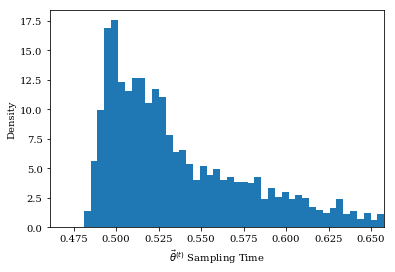

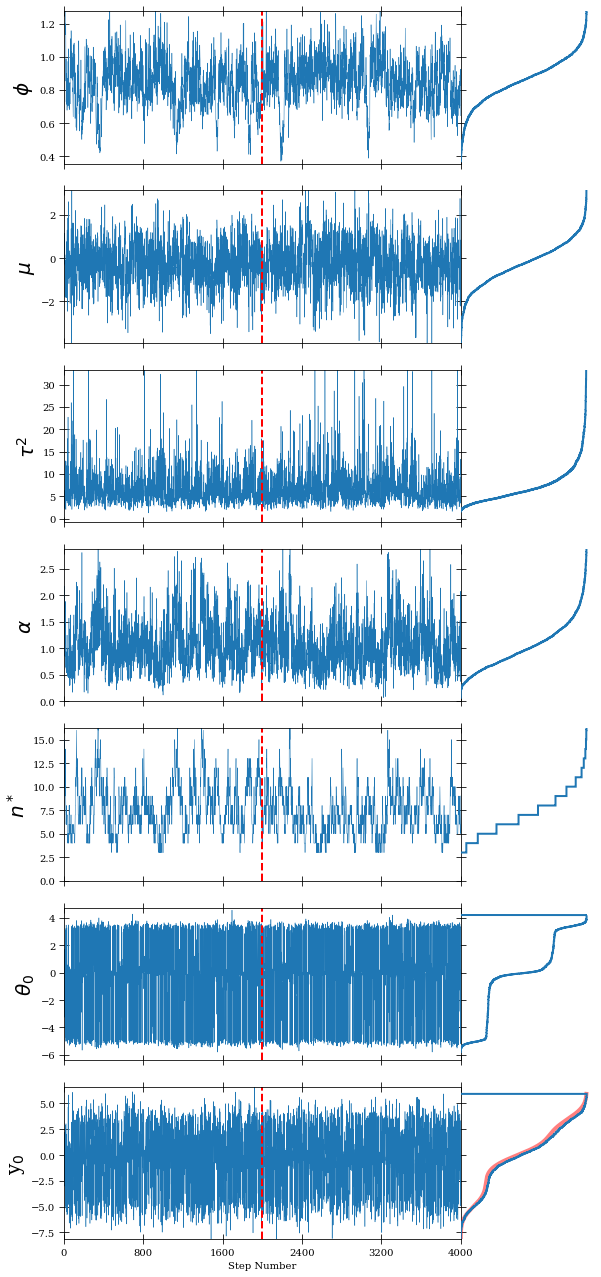

<Figure size 432x288 with 0 Axes>

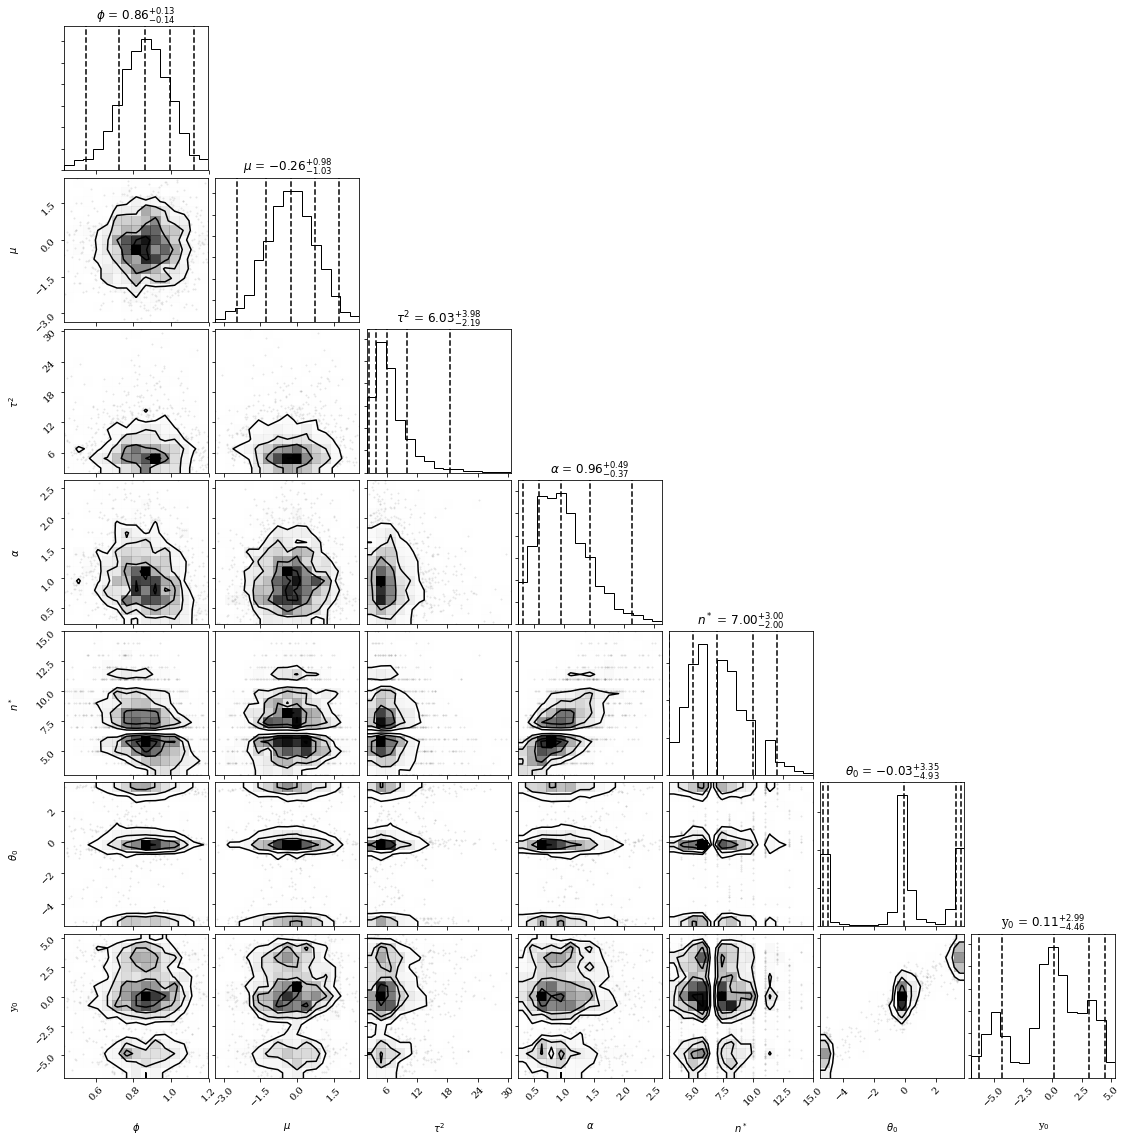

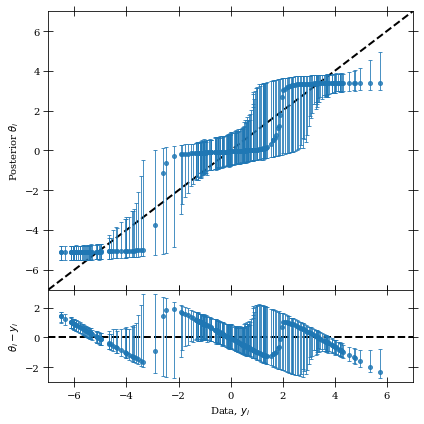

In [12]:
"""Plotting the results of the Metropolis-Hastings approach"""

burnin = n_obs//2

plt.figure()
plt.hist(runtimes['MH'][burnin:],bins=100,density=True)
plt.xlabel(r'$\vec \theta^{(t)}$ Sampling Time');plt.ylabel('Density')
xbound = np.percentile(runtimes['MH'][burnin:],[95])
xlim = plt.xlim()
plt.xlim(max(xlim[0],0),xbound)
plt.show()

samples = np.copy(mh_samples)

theta_vect_post = samples[:,:n]
phi_post = samples[:,n]
mu_post = samples[:,n+1]
tau2_post = samples[:,n+2]
alpha_post = samples[:,n+3]
theta0_post = samples[:,n+4]
y0_post = samples[:,n+5]
    
n_star_post = np.zeros(n_obs+1)

for i,theta_vect in enumerate(samples[:,:n]):
    n_star_post[i] = len(np.unique(theta_vect))

post_samples = np.array([phi_post,mu_post,tau2_post,alpha_post,\
                         n_star_post,theta0_post,y0_post]).T

plt.figure(figsize=np.array([10,3*len(dimLabels)])*0.85)
gs = gridspec.GridSpec(len(dimLabels),2,width_ratios=[3,1],wspace=0)

step_nums = np.arange(0,n_obs+1)
for i in range(len(dimLabels)):
    ax = plt.subplot(gs[i, 0])    
#    plt.subplot(len(dimLabels),1,i+1)
#    ax = plt.gca()
    samps = post_samples[burnin+1:,i]
    bounds = np.percentile(samps,[0.5,99.5])
    spread = bounds[1]-bounds[0]
    
    ax.tick_params(axis='both',direction='inout',length=10,
                    bottom=True,left=True,top=True,right=True)
    plt.plot(step_nums,post_samples[:,i],lw=0.5)
    plt.xlim(step_nums[0],step_nums[-1])
    plt.xticks(np.arange(0, n_obs+1, n_obs//5).astype(int))
    if i == len(dimLabels)-1:
        plt.xlabel('Step Number')
    else:
        ax.xaxis.set_ticklabels([])
    plt.axvline(burnin,c='r',ls='--',lw=2)
    plt.ylabel(dimLabels[i],fontsize=20)
    ylim = plt.ylim(bounds[0]-0.1*spread,bounds[1]+0.1*spread)
#    if 'phi' in dimLabels[i]:
#        plt.ylim(ylim[0],2.5)
#    elif 'tau' in dimLabels[i]:
#        plt.ylim(ylim[0],40)
    if 'n^*' in dimLabels[i]:
        plt.ylim(0,ylim[1])
    ylim = plt.ylim()
    
    ax_hist = plt.subplot(gs[i, 1])  
    ax_hist.axis('off')
    if dimLabels[i] == r'y$_0$':
        ys = np.linspace(samps.min(),samps.max(),10000)
        cdf = data_gen(ys,pdf=False)
        plt.plot(cdf,ys,color='r',lw=4,zorder=-1000,alpha=0.5)
    plt.hist(samps,cumulative=True,lw=2,
             orientation='horizontal',density=True,
             bins=len(samps),histtype='step')
    plt.ylim(ylim)
    
plt.tight_layout()
#plt.savefig(f'{path}HW3_q2_traces_{mode}.png')
plt.show()

plt.figure()
corner.corner(post_samples[burnin:],labels=dimLabels,bins=15,
              quantiles=[0.025, 0.16, 0.5, 0.84, 0.975],show_titles=True,
              title_kwargs={"fontsize": 12},range=[0.99]*len(dimLabels))
#plt.savefig(f'{path}HW3_q2_cornerplot_{mode}.png')
plt.show()
    
plt.figure(figsize=[6,6])
gs = gridspec.GridSpec(2,1,height_ratios=[3,1],hspace=0)
theta_i_post = np.percentile(theta_vect_post[burnin+1:],[2.5,50,97.5],axis=0)
theta_i_post = np.array([theta_i_post[1],
                         theta_i_post[1]-theta_i_post[0],
                         theta_i_post[2]-theta_i_post[1]])
ax = plt.subplot(gs[0, 0])    
ax.tick_params(axis='both',direction='inout',length=10,
                bottom=True,left=True,top=True,right=True)
plt.ylabel(r'Posterior $\theta_i$')
plt.errorbar(data,theta_i_post[0],
             yerr=[theta_i_post[1],theta_i_post[2]],
             fmt='o',ms=4,alpha=0.8,
             elinewidth=1,capsize=2)
xlim = plt.xlim(-7,7)
ylim = plt.ylim(-7,7)
plt.plot(xlim,ylim,c='k',lw=2,zorder=-1000,ls='--')
plt.xlim(xlim);plt.ylim(ylim)
ax.xaxis.set_ticklabels([])

ax = plt.subplot(gs[1, 0])    
ax.tick_params(axis='both',direction='inout',length=10,
                bottom=True,left=True,top=True,right=True)
plt.axhline(0,c='k',lw=2,zorder=-1000,ls='--')
plt.errorbar(data,theta_i_post[0]-data,
             yerr=[theta_i_post[1],theta_i_post[2]],
             fmt='o',ms=4,alpha=0.8,
             elinewidth=1,capsize=2)
plt.xlim(xlim)
plt.xlabel(r'Data, $y_i$')
plt.ylabel(r'$\theta_i - y_i$')
plt.tight_layout()
#plt.savefig(f'{path}HW3_q2_post_theta_vect_{mode}.png')
plt.show()


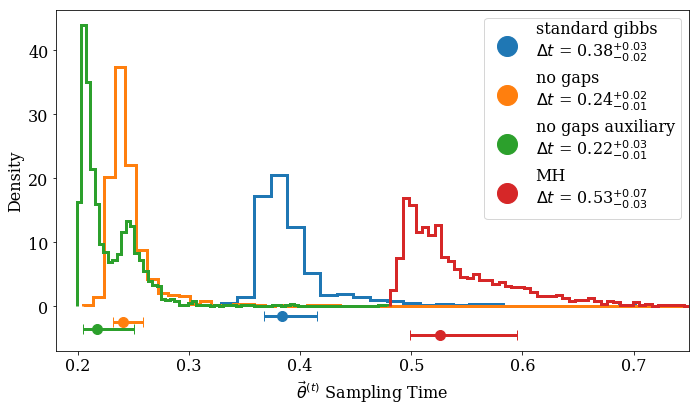

In [30]:
"""Comparing runtimes of methods"""

font = {'family' : 'serif',
#        'weight' : 'bold',
        'size'   : 16,}
matplotlib.rc('font', **font)

burnin = 2000
plt.figure(figsize=[10,6])
for i,method in enumerate(['standard gibbs','no gaps','no gaps auxiliary','MH']):
    label = method
    summary = np.percentile(runtimes[method][burnin:],[16,50,84])
    summary = np.array([summary[1],summary[1]-summary[0],summary[2]-summary[1]])
    sumstring = '%s\n$\Delta t$ = %.02f'%(method,summary[0])
    if '%.02f'%summary[1] == '%.02f'%summary[2]:
        sumstring += '$\pm$ %.02f'%(summary[1])
    else:
        sumstring += '$_{-%.02f}^{+%.02f}$'%(summary[1],summary[2])
    plt.hist(runtimes[method][burnin:],density=True,lw=3,histtype='step',bins=70,color='C%d'%i)
    plt.errorbar(summary[0],-1.5-1*(i),
                 xerr=[[summary[1]],[summary[2]]],
                 color='C%d'%i,zorder=10000+i,label=sumstring,
                 fmt='o',ms=10,alpha=1.0,elinewidth=3,capsize=5)
plt.legend(loc='best',markerscale=2)
plt.xlabel(r'$\vec \theta^{(t)}$ Sampling Time');plt.ylabel('Density')
xlim = plt.xlim()
plt.xlim(max(xlim[0],0.18),0.75)
plt.tight_layout()
plt.show()


n_star standard gibbs 288.94303235020885
n_star no gaps 59.00288676082693
n_star no gaps auxiliary 26.366358463966176
n_star MH 32.418938957419805


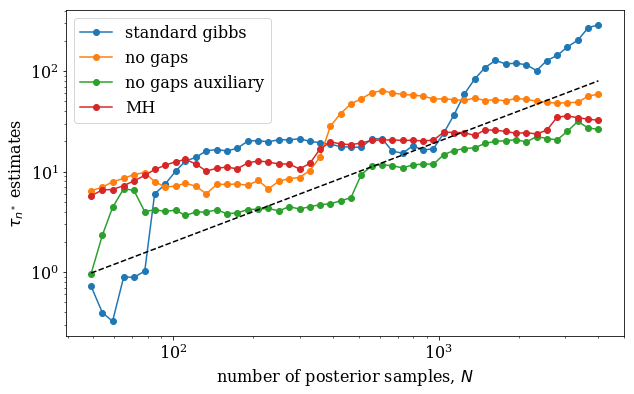

theta_1 standard gibbs 2.9055759043570477
theta_1 no gaps 1.6677540733068423
theta_1 no gaps auxiliary 1.7437943878300937
theta_1 MH 1.3277800899622676


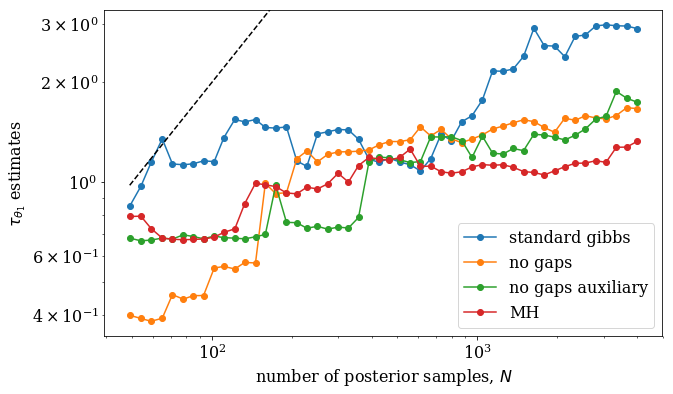

In [78]:
"""Comparing autocorrelation times of methods (for n^* and \theta_1)"""

def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2*n)
    acf = np.fft.ifft(f * np.conjugate(f))[:len(x)].real
    acf /= 4*n
    
    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

def autocorr_new(y, c=5.0):
    f = autocorr_func_1d(y)
    taus = 2.0*np.cumsum(f)-1.0
    window = auto_window(taus, c)
    return taus[window]

n = len(data)
# Compute the estimators for a few different chain lengths
N = np.exp(np.linspace(np.log(50), np.log(post_samples.shape[0]), 50)).astype(int)
autocorr_times_dict = {}
for method in ['standard gibbs','no gaps','no gaps auxiliary','MH']:
    if method == 'standard gibbs':
        samples = np.copy(standard_gibbs_samples)
    elif method == 'no gaps':
        samples = np.copy(no_gaps_samples)
    elif method == 'no gaps auxiliary':
        samples = np.copy(no_gaps_aux_samples)
    elif method == 'MH':
        samples = np.copy(mh_samples)
    theta_vect_post = samples[:,:n]
    phi_post = samples[:,n]
    mu_post = samples[:,n+1]
    tau2_post = samples[:,n+2]
    alpha_post = samples[:,n+3]
    theta0_post = samples[:,n+4]
    y0_post = samples[:,n+5]

    n_star_post = np.zeros(n_obs+1)

    for i,theta_vect in enumerate(samples[:,:n]):
        n_star_post[i] = len(np.unique(theta_vect))

    y = n_star_post
    autocorr_times = np.empty(len(N))
    for i, nn in enumerate(N):
        autocorr_times[i] = autocorr_new(y[:nn])
    autocorr_times_dict[method] = autocorr_times
    print('n_star',method,autocorr_times[-1])

plt.figure(figsize=[10,6])
for i,method in enumerate(['standard gibbs','no gaps','no gaps auxiliary','MH']):
    label = method
    # Plot the comparisons
    plt.loglog(N, autocorr_times_dict[method], "o-", label=label)
plt.legend(loc='best')
ylim = plt.gca().get_ylim()
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
#plt.axhline(true_tau, color="k", label="truth", zorder=-100)
plt.ylim(ylim)
plt.xlabel("number of posterior samples, $N$")
plt.ylabel(r"$\tau_{n^*}$ estimates")
plt.show()

autocorr_times_dict = {}
for method in ['standard gibbs','no gaps','no gaps auxiliary','MH']:
    if method == 'standard gibbs':
        samples = np.copy(standard_gibbs_samples)
    elif method == 'no gaps':
        samples = np.copy(no_gaps_samples)
    elif method == 'no gaps auxiliary':
        samples = np.copy(no_gaps_aux_samples)
    elif method == 'MH':
        samples = np.copy(mh_samples)
    theta_vect_post = samples[:,:n]
    phi_post = samples[:,n]
    mu_post = samples[:,n+1]
    tau2_post = samples[:,n+2]
    alpha_post = samples[:,n+3]
    theta0_post = samples[:,n+4]
    y0_post = samples[:,n+5]

    n_star_post = np.zeros(n_obs+1)

    for i,theta_vect in enumerate(samples[:,:n]):
        n_star_post[i] = len(np.unique(theta_vect))

    y = theta_vect_post[:,0]
    autocorr_times = np.empty(len(N))
    for i, nn in enumerate(N):
        autocorr_times[i] = autocorr_new(y[:nn])
    autocorr_times_dict[method] = autocorr_times
    print('theta_1',method,autocorr_times[-1])

plt.figure(figsize=[10,6])
for i,method in enumerate(['standard gibbs','no gaps','no gaps auxiliary','MH']):
    label = method
    # Plot the comparisons
    plt.loglog(N, autocorr_times_dict[method], "o-", label=label)
plt.legend(loc='best')
ylim = plt.gca().get_ylim()
plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
#plt.axhline(true_tau, color="k", label="truth", zorder=-100)
plt.ylim(ylim)
plt.xlabel("number of posterior samples, $N$")
plt.ylabel(r"$\tau_{\theta_1}$ estimates")
plt.show()